Notebook for implementation and testing of convolutional autoencoder and convolutional autoencoder with skip connections

Tests were performed on CIFAR-10 dataset

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

from torch.autograd import Variable
import torch.optim as optim
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [18, 6]

In [ ]:
try:
  import data
  import dataset
  import utils
except:
  print("Remember to load the python files to colab") 

In [ ]:
!cd ..
!mkdir data
!cd data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2021-11-13 15:26:06--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  51.0MB/s    in 3.5s    

2021-11-13 15:26:10 (46.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
!pip install -U albumentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

     |████████████████████████████████| 102 kB 7.0 MB/s 
     |████████████████████████████████| 47.6 MB 68 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
train_data, test_data = data.load_cifar_10_data("cifar-10-batches-py")

idx_train = np.random.permutation(np.arange(0,len(train_data)))[:5000]
idx_test = np.random.permutation(np.arange(0,len(test_data)))[:2000]
train_data = train_data[idx_train]
test_data = test_data[idx_test]


In [ ]:
batch_size = 64

transform = A.Compose([
    A.Blur(blur_limit=4, always_apply=False, p=0.8),
    A.MultiplicativeNoise(multiplier=(0.7, 1.3), p=0.8),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4, brightness_by_max=True, always_apply=False, p=0.8),
    A.ISONoise(color_shift=(0.08, 0.15), intensity=(0.2, 0.3), always_apply=False, p=0.8),
    A.RandomToneCurve(scale=0.3, p=0.8)
])

preprocess_transform = A.Compose([
    A.Normalize(mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    
    ])



trainset = dataset.Cifar10AutoEncoderDataset(train_data, preprocess_transform, transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = dataset.Cifar10AutoEncoderDataset(test_data, preprocess_transform, transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
def denormalize(img):
  image = np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1)
  MEAN = 255 * np.array([0.5, 0.5, 0.5])
  STD = 255 * np.array([0.5, 0.5, 0.5])
  image = ((image * STD)+ MEAN).astype(int)
  return image

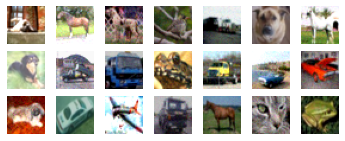

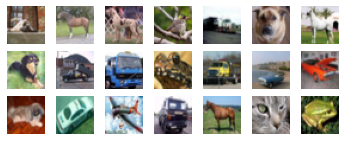

In [ ]:
images, labels = next(iter(train_loader))
plt.figure()

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(denormalize(images[i]))
    plt.axis('off')

plt.figure()

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(denormalize(labels[i]))
    plt.axis('off')

Old version, has a very big latent space - more like a U-net than autoencoder.
Here, the bottleneck encodes $4*4*128=2048$ features, which is close to $32*32*3=3072$ pixel values of hte input image

In [ ]:
### Old version, has a very big latent space - more like a unet than autoencoder

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)

    def forward(self, x): 
        # encoder
        e0 = F.leaky_relu(self.enc_conv0(x))
        e1 = F.leaky_relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.leaky_relu(self.enc_conv2(self.pool1(e1)))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv(self.pool2(e2)))
      
        # decoder
        d0 = F.leaky_relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.leaky_relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.leaky_relu(self.dec_conv2(self.upsample2(d1)))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

This version is actually more like an autoencoder, has a bottleneck that encodes $4*4*16 = 256$ features, which is a compression from $32*32*3 = 3072$ pixels of the input image (not a giant one, but okay given the variety of the images).

In [ ]:
class ConvAutoEncoder2(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder2, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(128, 16, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(16, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)

    def forward(self, x): 
        # encoder
        e0 = F.leaky_relu(self.enc_conv0(x))
        e1 = F.leaky_relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.leaky_relu(self.enc_conv2(self.pool1(e1)))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool2(e2)))))
       
        # decoder
        d0 = F.leaky_relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.leaky_relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.leaky_relu(self.dec_conv2(self.upsample2(d1)))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

[This](https://towardsdatascience.com/aligning-hand-written-digits-with-convolutional-autoencoders-99128b83af8b) article suggests that it is better to use upsampling/maxpooling instead of deconvolutions and convolutions with stride. Additionally, it shows that it is best to use fully connected layers for the bottleneck. I will test that here.

**Results**

The upsamling/maxpooling results in much worse training. The fully connected bottleneck seems to have simillar results as the convolutional. In the end, I will test the skip connections on both versions.

In [ ]:
class ConvAutoEncoder3(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder3, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.flatten = torch.nn.Flatten() # 4*4*128 = 2048
        self.bottleneck1 = nn.Linear(2048, 256)
        self.bottleneck2 =  nn.Linear(256, 2048)
        # self.bottleneck_conv1 = nn.Conv2d(128, 16, 3, padding=1)
        # self.bottleneck_conv2 = nn.Conv2d(16, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)

    def forward(self, x): 
        # encoder
        e0 = F.leaky_relu(self.enc_conv0(x))
        e1 = F.leaky_relu(self.enc_conv1(self.pool0(e0)))
        e2 = F.leaky_relu(self.enc_conv2(self.pool1(e1)))

        # bottleneck
        flat = self.flatten(self.pool2(e2))
        b = F.leaky_relu(self.bottleneck2(F.leaky_relu(self.bottleneck1(flat))))
        reshaped = torch.reshape(b, (-1,128,4,4))
        # b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool2(e2)))))
       
        # decoder
        d0 = F.leaky_relu(self.dec_conv0(self.upsample0(reshaped)))
        d1 = F.leaky_relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.leaky_relu(self.dec_conv2(self.upsample2(d1)))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

Autoencoder with skip connections

In [ ]:
class ConvAutoEncoderSkip(nn.Module):
    def __init__(self):
        super(ConvAutoEncoderSkip, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(64, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(256, 64, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(64)
        self.dec_dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(128, 32, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(32)
        self.dec_dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)


    def forward(self, x): 
        # encoder
        e0 = self.dropout0(F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x))))
        e1 = self.dropout1(F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0)))))
        e2 = self.dropout2(F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1)))))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool2(e2)))))
       
        # decoder
        d0 = self.dec_dropout0(F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(torch.cat([self.upsample0(b), e2], 1)))))
        d1 = self.dec_dropout1(F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1)))))
        d2 = self.dec_dropout2(F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1)))))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

In [ ]:
class ConvAutoEncoderSkipOld(nn.Module):
    def __init__(self):
        super(ConvAutoEncoderSkipOld, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(64, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(256, 64, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(64)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(128, 32, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(32)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)

    def forward(self, x): 
        # encoder
        # e0 = F.leaky_relu(self.enc_conv0(x))
        # e1 = F.leaky_relu(self.enc_conv1(self.pool0(e0)))
        # e2 = F.leaky_relu(self.enc_conv2(self.pool1(e1)))
        e0 = F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x)))
        e1 = F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0))))
        e2 = F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1))))

        # bottleneck
        b = F.leaky_relu(self.bottleneck_conv2(F.leaky_relu(self.bottleneck_conv1(self.pool2(e2)))))
       
        # decoder
        d0 = F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(torch.cat([self.upsample0(b), e2], 1))))
        d1 = F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1))))
        d2 = F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1))))
        # d0 = F.leaky_relu(self.dec_conv0(torch.cat([self.upsample0(b), e2], 1)))
        # d1 = F.leaky_relu(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1)))
        # d2 = F.leaky_relu(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1)))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

Version with fully connected bottleneck

In [ ]:
class ConvAutoEncoderSkip2(nn.Module):
    def __init__(self):
        super(ConvAutoEncoderSkip2, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.flatten = torch.nn.Flatten() # 4*4*128 = 2048
        self.bottleneck1 = nn.Linear(2048, 1024)
        self.bottleneck2 =  nn.Linear(1024, 2048)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(256, 64, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(64)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(128, 32, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(32)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)

    def forward(self, x): 
        # encoder
        e0 = F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x)))
        e1 = F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0))))
        e2 = F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1))))
        # e0 = F.leaky_relu(self.enc_conv0(x))
        # e1 = F.leaky_relu(self.enc_conv1(self.pool0(e0)))
        # e2 = F.leaky_relu(self.enc_conv2(self.pool1(e1)))

        # bottleneck
        flat = self.flatten(self.pool2(e2))
        b = F.leaky_relu(self.bottleneck2(F.leaky_relu(self.bottleneck1(flat))))
        reshaped = torch.reshape(b, (-1,128,4,4))
       
        # decoder
        d0 = F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(torch.cat([self.upsample0(reshaped), e2], 1))))
        d1 = F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1))))
        d2 = F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1))))
        # d0 = F.leaky_relu(self.dec_conv0(torch.cat([self.upsample0(reshaped), e2], 1)))
        # d1 = F.leaky_relu(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1)))
        # d2 = F.leaky_relu(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1)))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

In [ ]:
class ConvAutoEncoderSkip2Dropout(nn.Module):
    def __init__(self):
        super(ConvAutoEncoderSkip2Dropout, self).__init__()
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc_batchnorm_0 = nn.BatchNorm2d(32)
        self.dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool0 = nn.Conv2d(32, 32, 2, padding=0, stride=2)  # 32 -> 16
        self.enc_conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_batchnorm_1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool1 = nn.Conv2d(64, 64, 2, padding=0, stride=2)  # 16 -> 8
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_batchnorm_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.pool2 = nn.Conv2d(128, 128,2, padding=0, stride=2)  # 8 -> 4

        # bottleneck
        self.flatten = torch.nn.Flatten() # 4*4*128 = 2048
        self.bottleneck1 = nn.Linear(2048, 1024)
        self.bottleneck2 =  nn.Linear(1024, 2048)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128,128,2,stride=2)  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(256, 64, 3, padding=1)
        self.dec_batchnorm_0 = nn.BatchNorm2d(64)
        self.dec_dropout0 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)   # 8 -> 16
        self.dec_conv1 = nn.Conv2d(128, 32, 3, padding=1)
        self.dec_batchnorm_1 = nn.BatchNorm2d(32)
        self.dec_dropout1 = nn.Dropout2d(p=0.1, inplace=False)
        self.upsample2 = nn.ConvTranspose2d(32,32,2,stride=2)   # 16 -> 32
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec_batchnorm_2 = nn.BatchNorm2d(32)
        self.dec_dropout2 = nn.Dropout2d(p=0.1, inplace=False)
        self.dec_conv_fin = nn.Conv2d(32, 3, 1, padding=0)

    def forward(self, x): 
        # encoder
        e0 = self.dropout0(F.leaky_relu(self.enc_batchnorm_0(self.enc_conv0(x))))
        e1 = self.dropout1(F.leaky_relu(self.enc_batchnorm_1(self.enc_conv1(self.pool0(e0)))))
        e2 = self.dropout2(F.leaky_relu(self.enc_batchnorm_2(self.enc_conv2(self.pool1(e1)))))

        # bottleneck
        flat = self.flatten(self.pool2(e2))
        b = F.leaky_relu(self.bottleneck2(F.leaky_relu(self.bottleneck1(flat))))
        reshaped = torch.reshape(b, (-1,128,4,4))
       
        # decoder
        d0 = self.dec_dropout0(F.leaky_relu(self.dec_batchnorm_0(self.dec_conv0(torch.cat([self.upsample0(reshaped), e2], 1)))))
        d1 = self.dec_dropout1(F.leaky_relu(self.dec_batchnorm_1(self.dec_conv1(torch.cat([self.upsample1(d0), e1], 1)))))
        d2 = self.dec_dropout2(F.leaky_relu(self.dec_batchnorm_2(self.dec_conv2(torch.cat([self.upsample2(d1), e0], 1)))))
        out = F.tanh(self.dec_conv_fin(d2))
        return out

In [ ]:
def train(model, opt, epochs):

    def loss_fun(y_real, y_pred):
      # loss = nn.CrossEntropyLoss(weight=torch.tensor([1,5]).float().to(device))
      loss = torch.nn.MSELoss()
      # output = loss(y_pred, y_real.squeeze(1).long())
      output = loss(y_pred, y_real)
      return output

    X_val, Y_val = next(iter(test_loader))
    valid_loss_list = []
    train_loss_list = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        batch_loss_list = []
        # avg_loss = 0
        model.train()  # train mode
        for minibatch_no, (X_batch, Y_batch) in enumerate(train_loader, 0):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fun(Y_batch, Y_pred)  # forward-pass
            batch_loss_list.append(loss.item())
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            # avg_loss += loss / len(X_batch)
        toc = time()
        loss = np.mean(batch_loss_list)
        train_loss_list.append(loss)
        print(' - loss: %f' % loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()
        val_loss = loss_fun(Y_val, Y_hat)
        valid_loss_list.append(val_loss)
        predicted = Y_hat
        clear_output(wait=True)
        k = 0
        fig = plt.figure(figsize=(12,4))
        for m in range(6):
          plt.subplot(3, 6, k+1)
          plt.imshow(denormalize(X_val[m]))
          # plt.imshow(X_val[m][0].numpy(), cmap='gray')
          plt.title('Input')
          plt.axis('off')

          plt.subplot(3, 6, k+7)
          plt.imshow(denormalize(predicted[m]))
          # plt.imshow(predicted[m], cmap='gray')
          plt.title('Output')
          plt.axis('off')

          plt.subplot(3, 6, k+13)
          plt.imshow(denormalize(Y_val[m]))
          # plt.imshow(Y_val[m][0], cmap='gray')
          plt.title('Target')
          plt.axis('off')
          
          k+=1
        plt.suptitle('%d / %d - loss: %f , val loss: %f' % (epoch+1, epochs, loss, val_loss))
        plt.show()

        fig = plt.figure(figsize=(12,4))
        plt.plot(train_loss_list, 'b', label = "Train loss")
        plt.plot(valid_loss_list, 'orange', label = "Validation loss")
        plt.legend()
        plt.show()

First version - big latent space

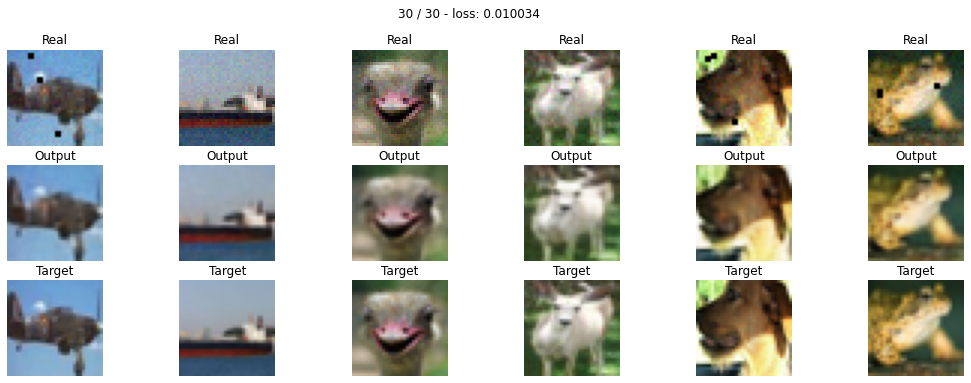

In [ ]:
model = ConvAutoEncoder().to(device)
train(model, optim.Adam(model.parameters()), 30)

Version 2 - decreased latent space

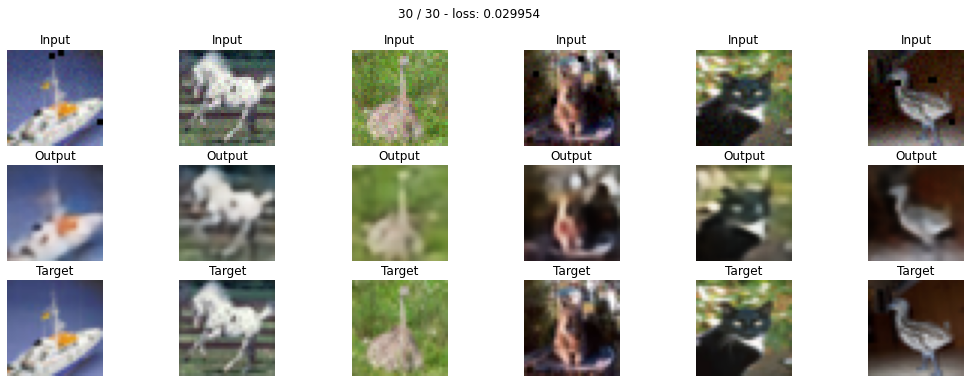

In [ ]:
model2 = ConvAutoEncoder2().to(device)
train(model2, optim.Adam(model2.parameters()), 30)

Version 3 - experiments on down/upsampling an fully connected bottleneck

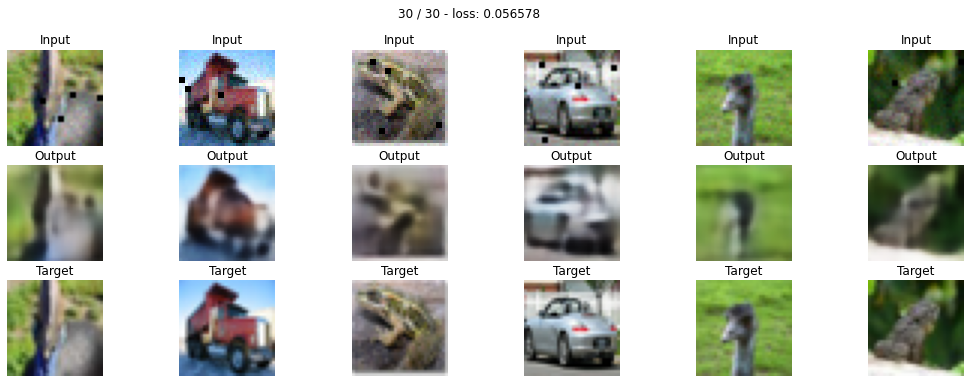

In [ ]:
model3 = ConvAutoEncoder3().to(device)
train(model3, optim.Adam(model3.parameters()), 30)

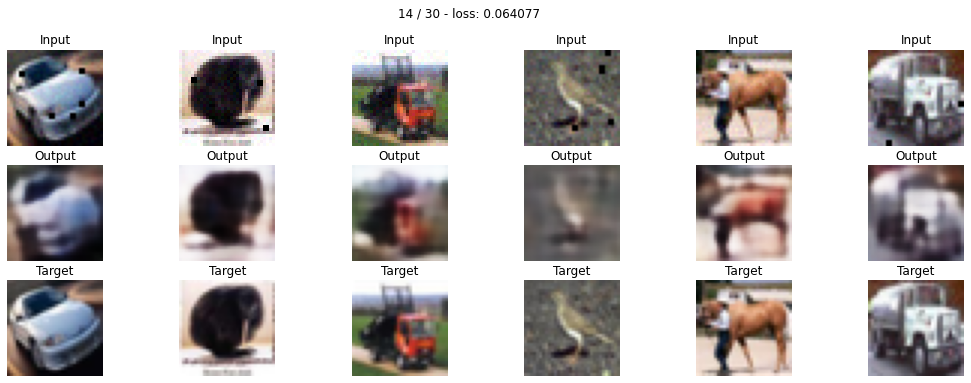

* Epoch 15/30


In [ ]:
# After removing fully connected layer
model3 = ConvAutoEncoder3().to(device)
train(model3, optim.Adam(model3.parameters()), 30)

In [ ]:
# After removing alternative downsampling/upsampling
model3 = ConvAutoEncoder3().to(device)
train(model3, optim.Adam(model3.parameters()), 30)

Version 4 - added skip connections

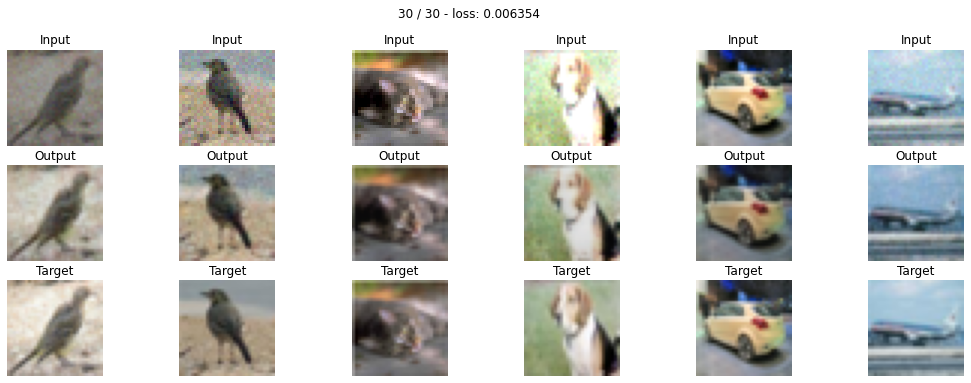

In [ ]:
modelSkip = ConvAutoEncoderSkip().to(device)
train(modelSkip, optim.Adam(modelSkip.parameters()), 30)

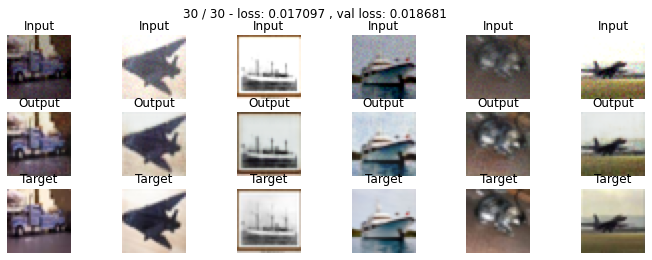

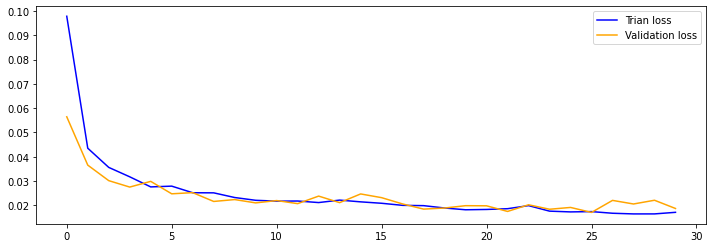

In [ ]:
modelSkip2 = ConvAutoEncoderSkip2().to(device)
train(modelSkip2, optim.Adam(modelSkip2.parameters()), 30)

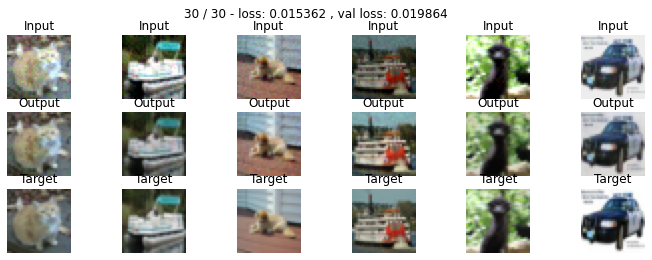

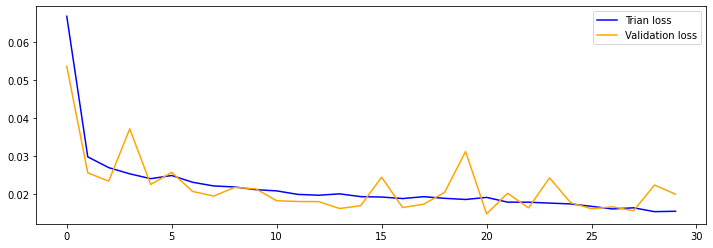

In [ ]:
# After adding batchnorm
modelSkip2 = ConvAutoEncoderSkip2().to(device)
train(modelSkip2, optim.Adam(modelSkip2.parameters(), lr=0.001), 30)

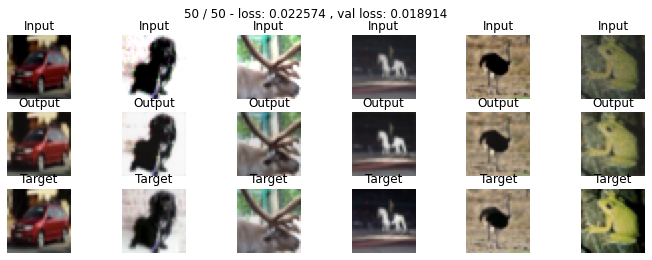

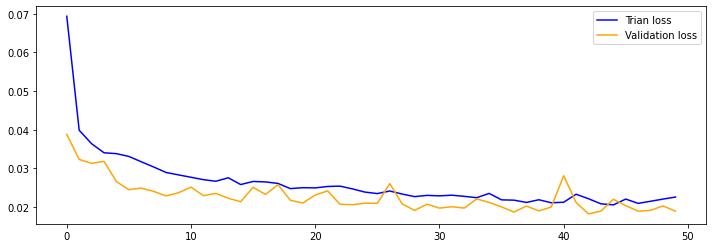

In [ ]:
#Batchnorm dropout fully connected botleneck
modelSkip2Dropout = ConvAutoEncoderSkip2Dropout().to(device)
train(modelSkip2Dropout, optim.Adam(modelSkip2Dropout.parameters(), lr=0.001), 50)

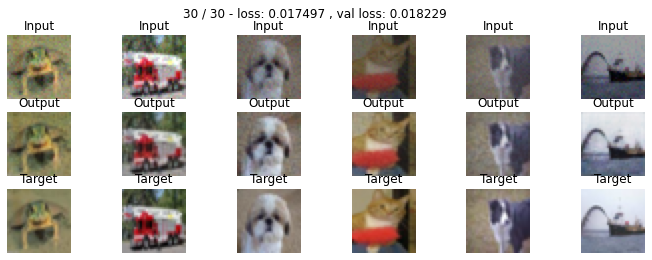

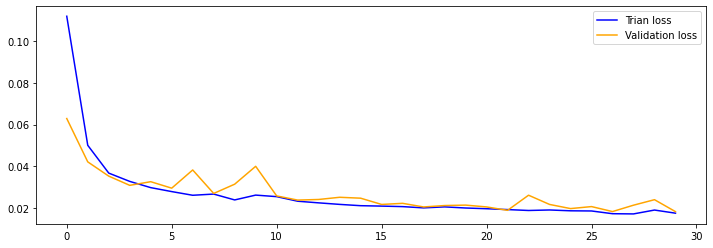

In [ ]:
# No dropout conv bottleneck
modelSkipOld = ConvAutoEncoderSkipOld().to(device)
train(modelSkipOld, optim.Adam(modelSkipOld.parameters(), lr=0.001), 30)

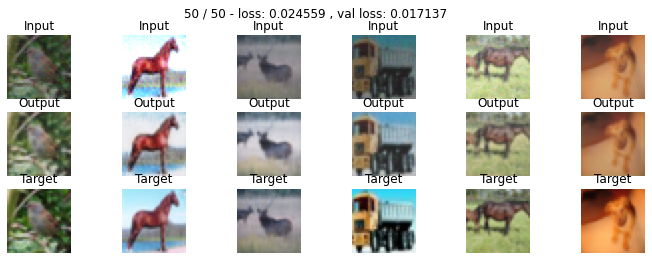

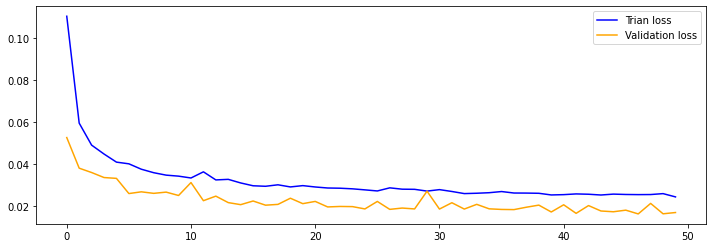

In [ ]:
# After adding dropout conv bottleneck
modelSkip = ConvAutoEncoderSkip().to(device)
train(modelSkip, optim.Adam(modelSkip.parameters(), lr=0.001), 50)

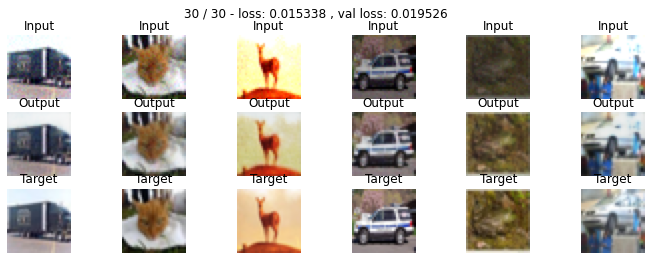

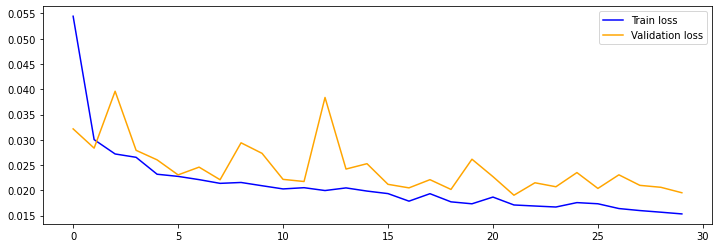

In [ ]:
#conv bottleneck batchnorm
modelSkipOld2 = ConvAutoEncoderSkipOld().to(device)
train(modelSkipOld2, optim.Adam(modelSkipOld2.parameters(), lr=0.001), 30)

Notes about the perfromance:
 * Tried decreasing learning rate but it seems that the default one (0.001) works the best at the moment
 * Batch normalization seems to stabilize the validation loss and decrease the loss very slightly
 * Increased the latent space size, since it seems that we aren't concerned about the "encoding" capabilities as long as the denoising works. It helped both for the "fully connected" bottleneck and the convolutional one. Now it seems that the network with convloutional bottleneck is slightly better, but it is not a big difference
 * Added dropout to all convolutional layers, increased the epoch amount to test it. As expected, the training loss is bigger, but I didn't see a decrease in the validation loss. After decreasing dropout to 0.1, the validation loss has decreased a bit

 

### Batch size test

used before is 128
Testing a smaller one first - 32



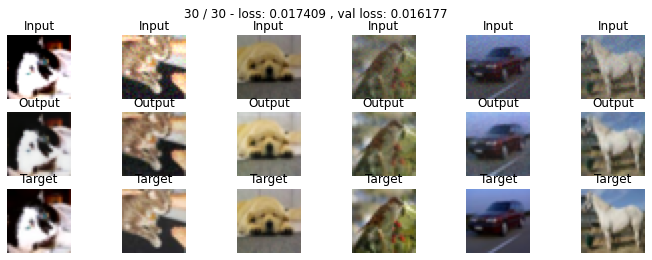

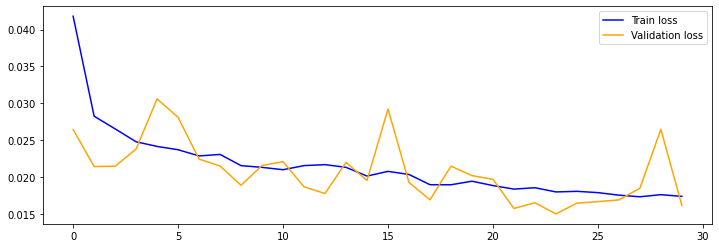

In [ ]:
modelSkipOld2 = ConvAutoEncoderSkipOld().to(device)
train(modelSkipOld2, optim.Adam(modelSkipOld2.parameters(), lr=0.001), 30)

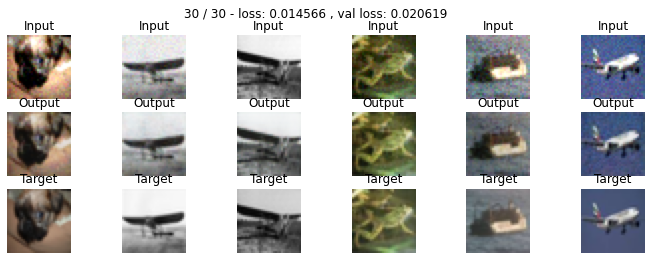

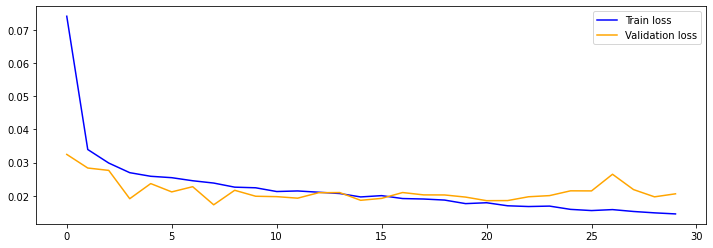

In [ ]:
modelSkipOld2 = ConvAutoEncoderSkipOld().to(device)
train(modelSkipOld2, optim.Adam(modelSkipOld2.parameters(), lr=0.0001), 30)

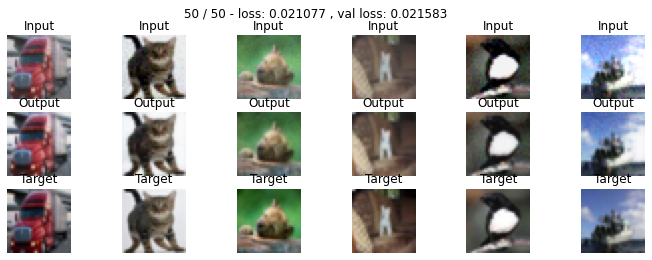

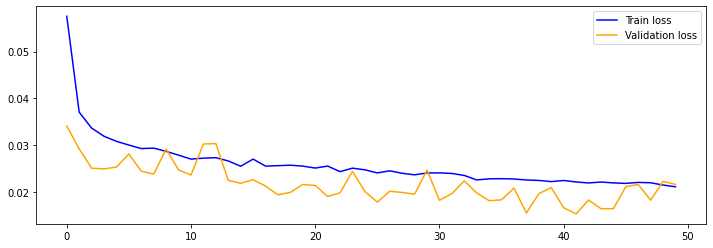

In [ ]:
modelSkip = ConvAutoEncoderSkip().to(device)
train(modelSkip, optim.Adam(modelSkip.parameters(), lr=0.001), 50)

Testing 64

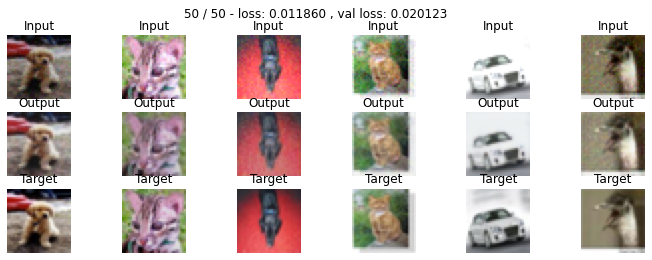

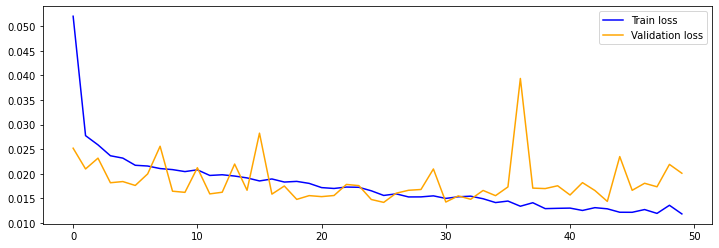

In [ ]:
modelSkipOld2 = ConvAutoEncoderSkipOld().to(device)
train(modelSkipOld2, optim.Adam(modelSkipOld2.parameters(), lr=0.001), 50)

Same with dropout

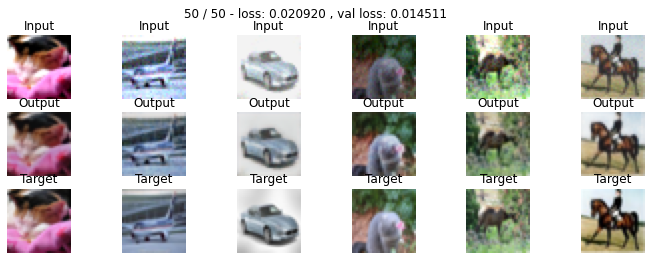

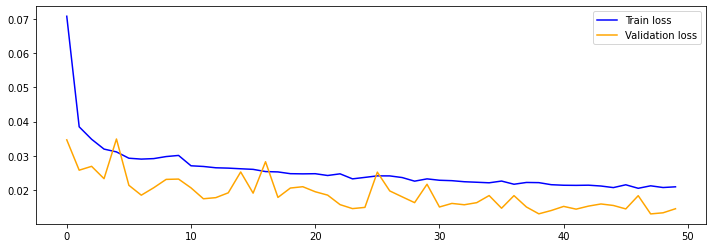

In [ ]:
modelSkip = ConvAutoEncoderSkip().to(device)
train(modelSkip, optim.Adam(modelSkip.parameters(), lr=0.001), 50)

Testing 256

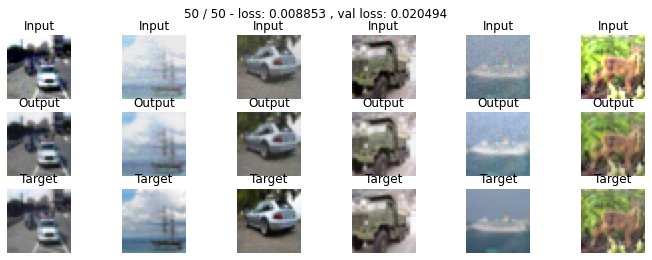

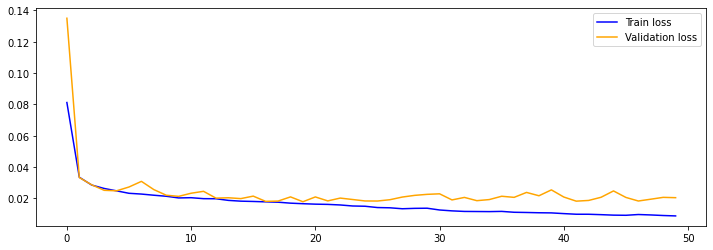

In [ ]:
modelSkipOld2 = ConvAutoEncoderSkipOld().to(device)
train(modelSkipOld2, optim.Adam(modelSkipOld2.parameters(), lr=0.001), 50)

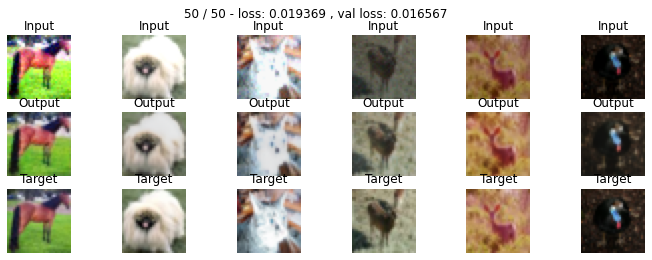

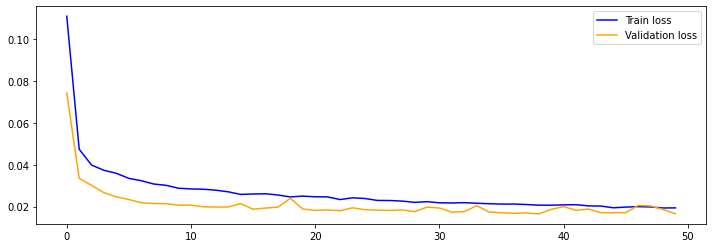

In [ ]:
modelSkip = ConvAutoEncoderSkip().to(device)
train(modelSkip, optim.Adam(modelSkip.parameters(), lr=0.001), 50)

It seems that the batch size of 64 is the best here. It also works best with dropout. 128 is fine, but produces slightly worse results, while 32 and 256 are visibly worse.